# CelebA 데이터셋
- shape= (218,178,3)
- 0.jpg~~~ 19999.jpg

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
!pip install torchvision
! pip install imageio

In [2]:
import torchvision.datasets
import h5py
import zipfile
import imageio
import os
import torch.nn as nn
from torch.utils.data import Dataset

In [3]:
%%time

# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = 'C:/Users/Songwooseok/wooseokcode/first GAN/celeba_dataset/celeba_aligned_small.h5py'

# how many of the 202,599 images to extract and package into HDF5
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0
    
    print(os.getcwd())
    #print(os.path.exists('celeba/img_align_celeba_20000.zip'))
    with zipfile.ZipFile('celeba/img_align_celeba_20000.zip', 'r') as zf:
      print("!")
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass

C:\Users\Songwooseok\wooseokcode\first GAN
!
images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
Wall time: 6min 29s


In [4]:
# import h5py to access data
import h5py

import numpy
import matplotlib.pyplot as plt

In [5]:

# open HDF5 file and list any groups

with h5py.File('C:/Users/Songwooseok/wooseokcode/first GAN/celeba_dataset/celeba_aligned_small.h5py','r') as file_object:
  for group in file_object:
    print(group)
    pass

img_align_celeba


(218, 178, 3)

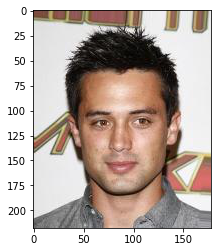

In [8]:

# open HDF5 file and list any groups

with h5py.File('C:/Users/Songwooseok/wooseokcode/first GAN/celeba_dataset/celeba_aligned_small.h5py','r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['6.jpg'])
  plt.imshow(image, interpolation='none')
  pass
image.shape # 높이 218,너비 178,  rgb 3개 레이어 

## 데이터셋 클래스

In [9]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

In [10]:
# create Dataset object

celeba_dataset = CelebADataset('C:/Users/Songwooseok/wooseokcode/first GAN/celeba_dataset/celeba_aligned_small.h5py')

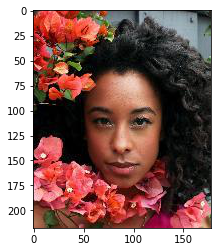

In [11]:
celeba_dataset.plot_image(43)

# 판별기

In [12]:
# (218,178,3) 3차원 텐서를 1차원 형태의 텐서 (218 *127*3)으로 바꿔줌

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [13]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## 판별기 테스트 하기

In [14]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

#생성기에 투입할 떄마다 쓰는 것 
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
%%time
D= Discriminator()
for image_data_tensor in celeba_dataset:
    #실제 데이터 
    D.train(image_data_tensor,torch.FloatTensor([1.0]))
    #생성된 데이터 
    D.train(generate_random_image((218,178,3)),torch.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000


In [ ]:

# plot discriminator loss

D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
  pass

# 생성기

In [ ]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
# 훈련 전 생성기 결과 확인하기
G= Generator()

output = G.forward(generate_random_seed(100))
img = output.detach().numpy()
plt.imshow(img, interpolation='none',cmap='Blues')

# GAN 훈련하기

In [ ]:
%%time 

# create Discriminator and Generator

D = Discriminator()
#D.to(device)
G = Generator()
#G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # train discriminator on true
    #D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    #D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))
    #G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

In [ ]:
D.plot_progress()

In [ ]:
G.plot_progress()

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        #img = output.detach().cpu().numpy()
        img = output.detach().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass